# Задание
* Скачать все вакансии СБЕРа с ХХ (у апи есть ограничение в 2000, а также captcha подумайте как их можно обойти)
* Извлеките все описания этих вакансий
* Создайте аналогичный vacancy DataFrame только добавьте поле skills
* Переведите даты публикаций в datetime
* Постройте график опубликованных вакансий по датам
* Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
* Найдите те вакансии с использованием python, которые вам интересны
* Определите по полю skills какие навыки больше всего востребованы для этих вакансий
* Постройте график наиболее востребованных навыков для аналитика данных

In [2]:
import requests
import json
from tqdm.auto import tqdm
from collections import defaultdict, Counter
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\mikha\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [4]:
sber = '3529'
page = 1
num_per_page = 100
moscow = 1
url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}'

In [5]:
res = requests.get(url)

# res.json()

vacancies = res.json()
num_pages = vacancies.get('pages')
num_pages

12

In [6]:
vacancies = res.json()
num_pages = vacancies.get('pages')
vacancy_ids = [el.get('id') for el in vacancies.get('items')]

In [7]:
vacancies.keys()

dict_keys(['items', 'found', 'pages', 'per_page', 'page', 'clusters', 'arguments', 'alternate_url'])

In [8]:
vacancies.get('items')

[{'id': '51784863',
  'premium': False,
  'name': 'Data Scientist (SberDevices)',
  'department': {'id': '3529-3529-it', 'name': 'Сбер. IT'},
  'has_test': False,
  'response_letter_required': False,
  'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
  'salary': None,
  'type': {'id': 'open', 'name': 'Открытая'},
  'address': {'city': 'Москва',
   'street': 'Кутузовский проспект',
   'building': '32',
   'description': None,
   'lat': 55.740421,
   'lng': 37.532071,
   'raw': 'Москва, Кутузовский проспект, 32',
   'metro': {'station_name': 'Кутузовская',
    'line_name': 'МЦК',
    'station_id': '95.536',
    'line_id': '95',
    'lat': 55.740833,
    'lng': 37.533333},
   'metro_stations': [{'station_name': 'Кутузовская',
     'line_name': 'МЦК',
     'station_id': '95.536',
     'line_id': '95',
     'lat': 55.740833,
     'lng': 37.533333}],
   'id': '823806'},
  'response_url': None,
  'sort_point_distance': None,
  'published_at': '2022-06-23T13:06:32+030

In [9]:
hh_data = pd.DataFrame(vacancies.get('items'))
hh_data.columns

Index(['id', 'premium', 'name', 'department', 'has_test',
       'response_letter_required', 'area', 'salary', 'type', 'address',
       'response_url', 'sort_point_distance', 'published_at', 'created_at',
       'archived', 'apply_alternate_url', 'insider_interview', 'url',
       'adv_response_url', 'alternate_url', 'relations', 'employer', 'snippet',
       'contacts', 'schedule', 'working_days', 'working_time_intervals',
       'working_time_modes', 'accept_temporary'],
      dtype='object')

In [10]:
vnum = vacancies.get('pages')

In [11]:
all_vacancy_ids= []
for i in tqdm(range(vnum)):
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={i}&per_page={num_per_page}&area={moscow}'
    res = requests.get(url)
    vacancies = res.json()
    vacancy_ids = [el.get('id') for el in vacancies.get('items')]
    all_vacancy_ids.extend(vacancy_ids)
all_vacancy_ids

100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


['55415805',
 '55415496',
 '53361761',
 '66978838',
 '45790891',
 '67549809',
 '67381964',
 '67233281',
 '67504369',
 '45381514',
 '67091943',
 '67430140',
 '66954559',
 '66944945',
 '67122198',
 '67472833',
 '67513624',
 '55101523',
 '67353952',
 '67525338',
 '67451281',
 '66701179',
 '67157362',
 '66940144',
 '67349462',
 '67494236',
 '67054830',
 '67119655',
 '66697224',
 '67508678',
 '66589132',
 '66853831',
 '67498612',
 '67080367',
 '67536843',
 '66768015',
 '66832293',
 '67352254',
 '66695633',
 '67362093',
 '67291400',
 '67385129',
 '67471058',
 '67438892',
 '67375671',
 '67055135',
 '67073420',
 '66996218',
 '67540818',
 '67430715',
 '67352204',
 '67255863',
 '66634517',
 '67006080',
 '67086669',
 '66986411',
 '67513649',
 '67537880',
 '66917892',
 '67475345',
 '66809685',
 '66998454',
 '67338661',
 '66919404',
 '54924012',
 '66937574',
 '67353137',
 '67235538',
 '66874002',
 '67289493',
 '66080775',
 '67377246',
 '66814294',
 '67225348',
 '66873267',
 '66837955',
 '67489064',

In [12]:
#* Создайте аналогичный vacancy DataFrame только добавьте поле skills
total_data = []
for i in tqdm(range(len(all_vacancy_ids))): # забираем по id вакансий
    url = f'https://api.hh.ru/vacancies/{all_vacancy_ids[i]}'
    res = requests.get(url)
    result = res.json()
    total_data.append(result) # получили список из списков словарей. Работать с этим тяжело
total_data = pd.DataFrame(total_data)
total_data.columns # есть поле key skills!

#Добавим отдельное поле со списком навыков

total_data['skills'] = np.empty((len(total_data), 0)).tolist()

for i in range(len(total_data['key_skills'])):
    for j in range(len(total_data.loc[i, 'key_skills'])):
        total_data.loc[i,'skills'].append(total_data['key_skills'][i][j].get('name'))

100%|██████████| 1197/1197 [04:52<00:00,  4.10it/s]


In [13]:
#Переведите даты публикаций в datetime


total_data['published_at'] = pd.to_datetime(total_data['published_at'])

published_at
2022-06-06      1
2022-06-07     15
2022-06-08     16
2022-06-09     15
2022-06-10     18
2022-06-11      2
2022-06-14     52
2022-06-15     43
2022-06-16     48
2022-06-17     41
2022-06-18      2
2022-06-19      1
2022-06-20     63
2022-06-21     49
2022-06-22     56
2022-06-23     47
2022-06-24     42
2022-06-25      3
2022-06-26     30
2022-06-27     92
2022-06-28     68
2022-06-29     71
2022-06-30     71
2022-07-01     40
2022-07-02      4
2022-07-03      8
2022-07-04    107
2022-07-05    106
2022-07-06     86
Name: id, dtype: int64


<BarContainer object of 29 artists>

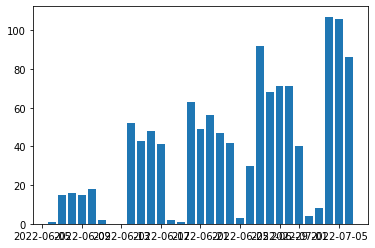

In [14]:
#Постройте график опубликованных вакансий по датам

vacancies_published = total_data.groupby(total_data['published_at'].dt.date)['id'].count()
print(vacancies_published)

plt.bar(vacancies_published.index, vacancies_published)

In [15]:
#Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
weekdays_published = total_data.groupby(total_data['published_at'].dt.day_name())['id'].count()
weekdays_published.sort_values(ascending = False).head(1)

published_at
Tuesday    290
Name: id, dtype: int64

In [17]:

#Найдите те вакансии с использованием python, которые вам интересны
# интересны вакансии с известной зп от 90 000 и в Москве
# хотелось бы 200, но такой стартовой нет
# в вакансиях с Python зарплата не указана. Обидно!

preferred_vacancies = total_data.copy()

for i in preferred_vacancies.index: 
    preferred_vacancies.loc[i,'city'] = preferred_vacancies.loc[i,'area'].get('name')
    preferred_vacancies.loc[i,'wage'] = preferred_vacancies.loc[i, 'salary'].get('from')

preferred_vacancies_with_python = preferred_vacancies[(preferred_vacancies['wage'] >= 90000)&(preferred_vacancies['city'] == 'Москва')&(preferred_vacancies.skills.apply(lambda x: 'Python' in x))]
preferred_vacancies_wo_python = preferred_vacancies[(preferred_vacancies['wage'] >= 90000)&(preferred_vacancies['city'] == 'Москва')]
vacancies_with_python = preferred_vacancies[preferred_vacancies.skills.apply(lambda x: 'Python' in x)]

AttributeError: 'NoneType' object has no attribute 'get'

Проведение презентаций    1
Активные продажи          1
Привлечение клиентов      1
Навыки продаж             1
dtype: int64


<AxesSubplot:>

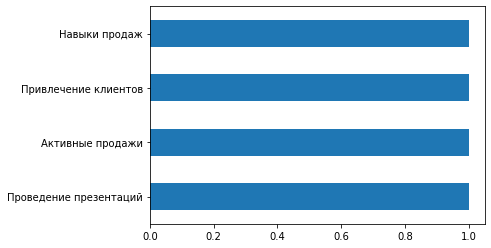

In [37]:
#Определите по полю skills какие навыки больше всего востребованы для этих вакансий
preferred_skills = preferred_vacancies_wo_python.skills.apply(pd.Series).stack().reset_index(drop = True)
print(preferred_skills.value_counts())

preferred_skills.value_counts().plot(kind='barh')

In [36]:
preferred_skills.value_counts()

Index(['Проведение презентаций', 'Активные продажи', 'Привлечение клиентов',
       'Навыки продаж'],
      dtype='object')

SQL                      6
Python                   4
Hadoop                   4
Spark                    3
Hive                     2
Английский язык          1
PostgreSQL               1
Numpy                    1
Atlassian Jira           1
Ad Hoc Analysis          1
pandas                   1
A/B тесты                1
Linux                    1
XML                      1
Git                      1
Администрирование        1
Математический анализ    1
NoSQL                    1
Pandas                   1
ETL                      1
Kafka                    1
ML                       1
Машинное обучение        1
Системный анализ         1
Анализ данных            1
dtype: int64


<AxesSubplot:>

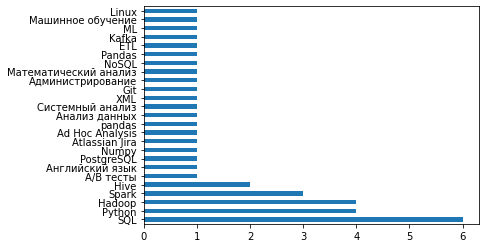

In [39]:
#Постройте график наиболее востребованных навыков для аналитика данных

analysts = total_data[total_data['name'].str.lower().str.contains('data analyst|аналитик данных',na=False)]
analysts_skills = analysts.skills.apply(pd.Series).stack().reset_index(drop = True)
print(analysts_skills.value_counts())

analysts_skills.value_counts().sort_values(ascending = False).plot(kind='barh')